Hasil forecasting dari model SARIMA ini memberikan dasar yang solid untuk perencanaan operasional dan strategi pemasaran perusahaan. 

Dengan memproyeksikan lonjakan penumpang pada **peak season**, perusahaan dapat secara proaktif menyiapkan sumber daya yang diperlukan, seperti staf tambahan atau optimalisasi fasilitas. 
Selain itu, **data ini membantu tim pemasaran dalam menentukan target yang tepat dalam merancang kampanye pemasaran**.

# Import Library dan Explore Gambaran Besar Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = sns.load_dataset('flights')
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


tidak ada data / bulan yang kosong

In [3]:
df.year.value_counts()

1949    12
1950    12
1951    12
1952    12
1953    12
1954    12
1955    12
1956    12
1957    12
1958    12
1959    12
1960    12
Name: year, dtype: int64

Menambahkan Kolom Baru untuk Menunjukkan Bulan dan Tahun

In [4]:
df['month_year'] = pd.to_datetime('01-'+df['month'].astype(str)+'-'+df['year'].astype(str))

## Missing and Duplicate Value check

data tidak memiliki missing value

In [5]:
df.isna().sum()

year          0
month         0
passengers    0
month_year    0
dtype: int64

data tidak memiliki duplicated value

In [6]:
df[df.duplicated()]

,year,month,passengers,month_year


## Membuat Data menjadi Format Time Series

In [7]:
df.set_index('month_year', inplace=True)
df = df[['passengers']]
df.head()

,passengers
month_year,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


# EDA

<AxesSubplot:xlabel='month_year', ylabel='passengers'>

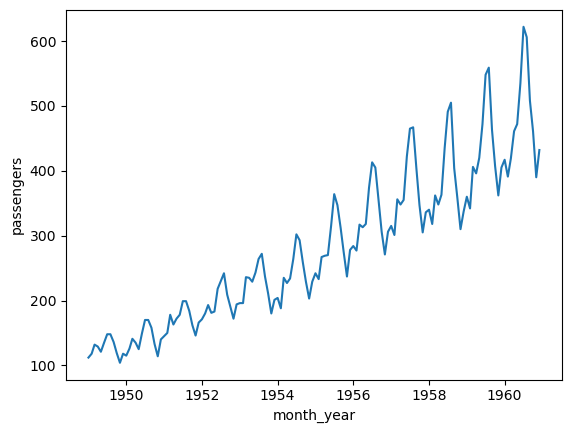

In [9]:
sns.lineplot(df.index, df['passengers'])

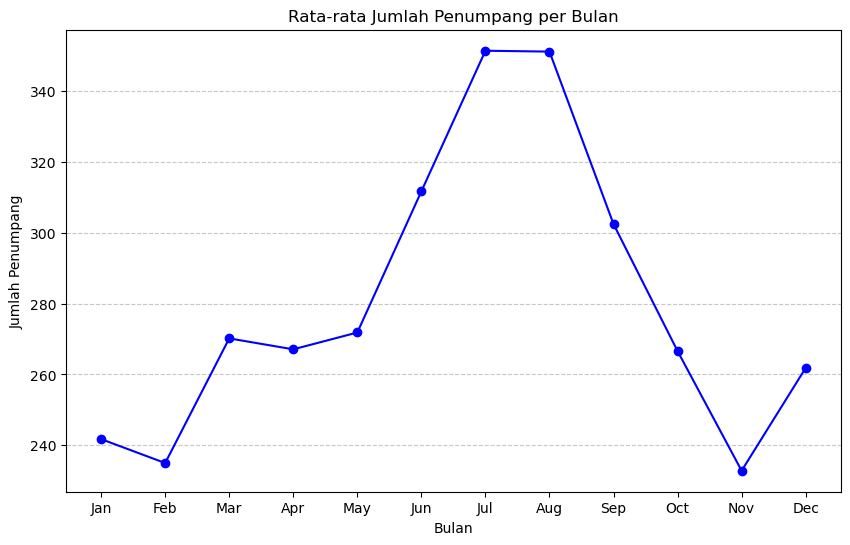

In [10]:
# Menghitung rata-rata penumpang per bulan
monthly_mean = df.groupby(df.index.month).mean()

# Ubah nama bulan menjadi nama bulan yang sesuai
monthly_mean.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot rata-rata penumpang per bulan
plt.figure(figsize=(10, 6))
plt.plot(monthly_mean.index, monthly_mean['passengers'], color='blue', marker='o')
plt.title('Rata-rata Jumlah Penumpang per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Penumpang')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Lonjakan jumlah penumpang pada bulan Juli dan Agustus yang kemudian menurun di bulan September bisa disebabkan oleh beberapa faktor umum yang sering terjadi dalam data penumpang. Berikut beberapa kemungkinan penyebabnya:

**Liburan Musim Panas:**

Di banyak negara, bulan Juli dan Agustus adalah musim liburan sekolah dan universitas. Keluarga dan pelajar sering melakukan perjalanan selama periode ini, yang dapat menyebabkan lonjakan penumpang.
Cuti dan Liburan: Banyak orang mengambil cuti atau liburan musim panas, sehingga mempengaruhi jumlah perjalanan dan penumpang.
Kegiatan Musiman:

**Acara Musiman** 

Bulan Juli dan Agustus sering kali memiliki banyak acara, festival, dan kegiatan khusus yang menarik wisatawan. Ini juga bisa menjelaskan lonjakan penumpang.
Cuaca: Cuaca yang lebih baik di musim panas mungkin mendorong lebih banyak orang untuk bepergian.
Mulai Sekolah:

Kembali ke Sekolah: Pada bulan September, banyak sekolah dan universitas mulai kembali aktif, sehingga orang tua dan pelajar yang melakukan perjalanan pada musim panas kembali ke rutinitas mereka. Ini dapat menyebabkan penurunan jumlah penumpang.

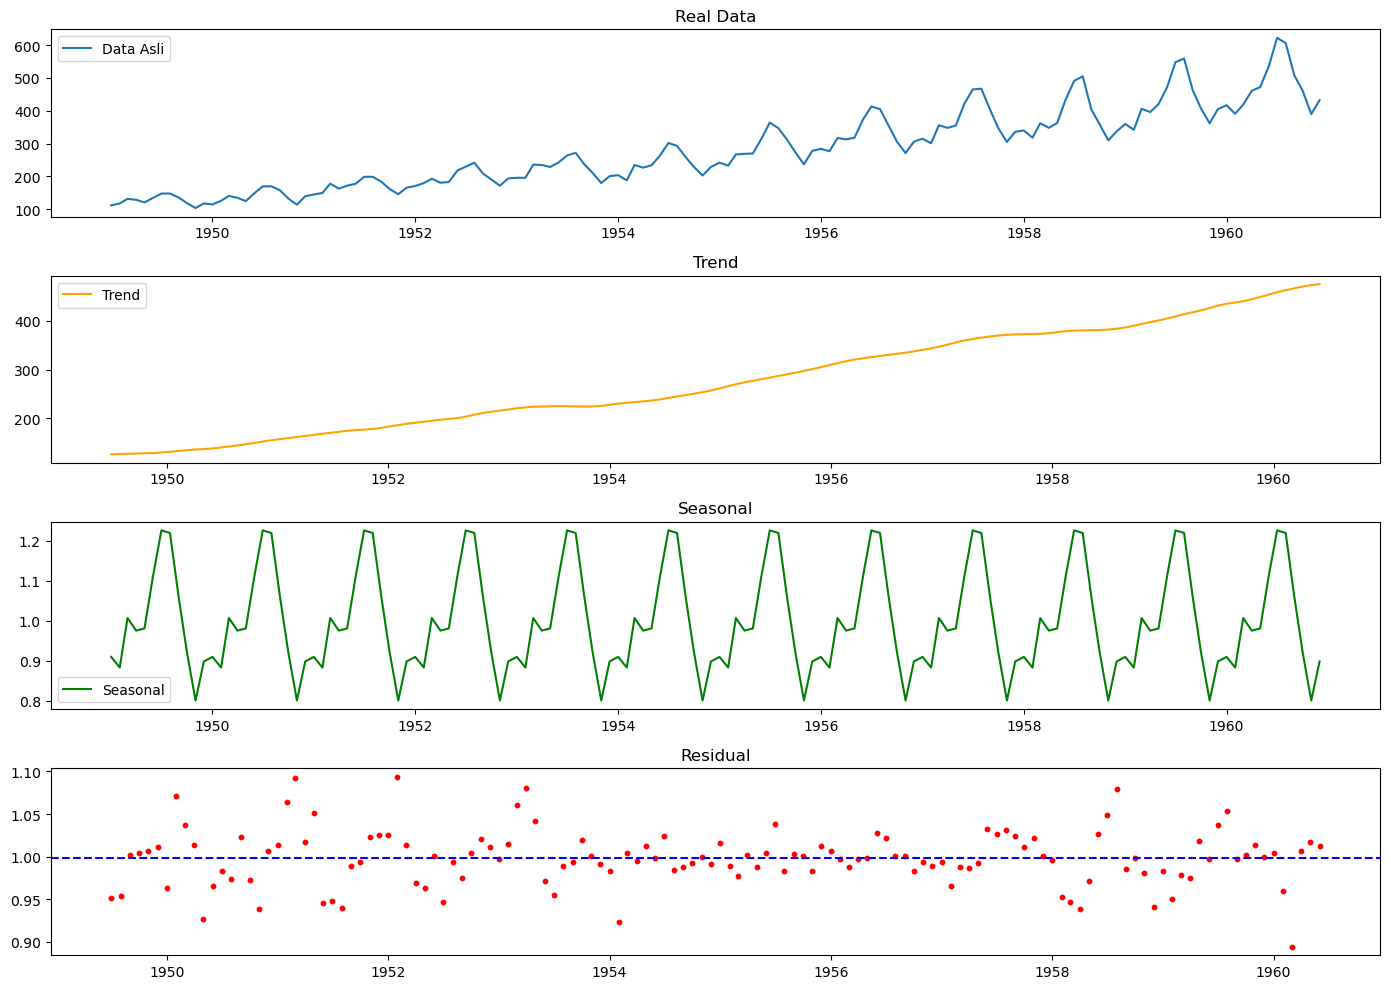

In [11]:
# Dekomposisi time series
decomposition = seasonal_decompose(df['passengers'], model='multiplicative')

# Hitung residuals dan rata-ratanya
residuals = decomposition.resid.dropna()
mean_residuals = residuals.mean()

# Plot hasil dekomposisi
plt.figure(figsize=(14, 10))

# Plot data asli
plt.subplot(4, 1, 1)
plt.plot(df.index, df['passengers'], label='Data Asli')
plt.title('Real Data')
plt.legend()

# Plot trend
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend.dropna(), label='Trend', color='orange')
plt.title('Trend')
plt.legend()

# Plot musiman
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.title('Seasonal')
plt.legend()

# Plot residual dengan scatter plot dan garis tengah
plt.subplot(4, 1, 4)
plt.scatter(residuals.index, residuals, color='red', s=10, label='Residuals')
plt.axhline(y=mean_residuals, color='blue', linestyle='--', label='Rata-Rata Residuals')
plt.title('Residual')

plt.tight_layout()
plt.show()

Setelah melakukan dekomposisi pada data, saya dapat menyimpulkan bahwa data menunjukkan adanya **Trend** dan **efek musiman (seasonal)**. Selain itu, data juga **tidak bersifat stasioner**.

# Split Train and Test Data

In [12]:
df.shape

(144, 1)

In [13]:
train = df[:round(len(df)*70/100)]
test = df[round(len(df)*70/100):]

print('Train : ',train.shape[0])
print('Test  : ',test.shape[0])

Train :  101
Test  :  43


# Modelling

## ETS (Exponential Smoothing Time Series)

C:\Users\muham\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


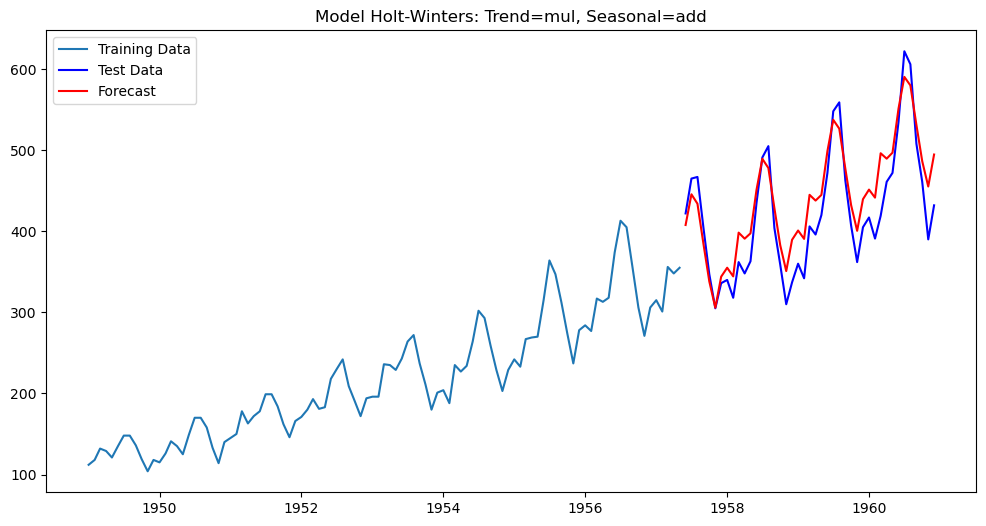

Root Mean Squared Error (mul, add): 34.05


C:\Users\muham\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


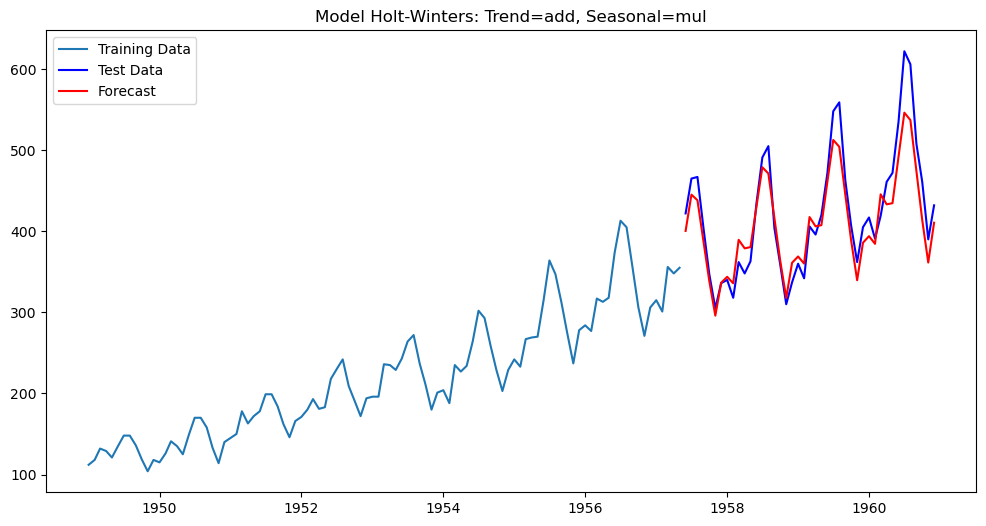

Root Mean Squared Error (add, mul): 27.97


C:\Users\muham\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


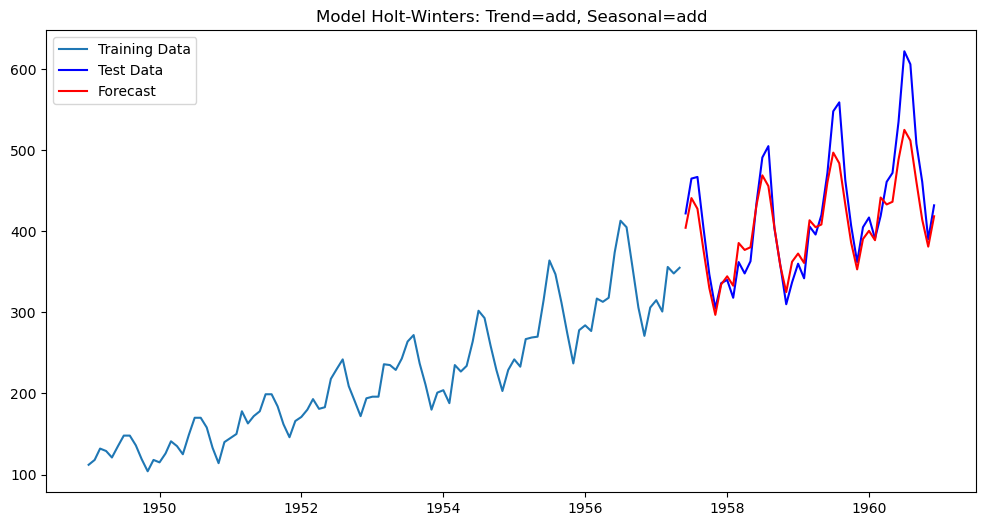

Root Mean Squared Error (add, add): 33.39


C:\Users\muham\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


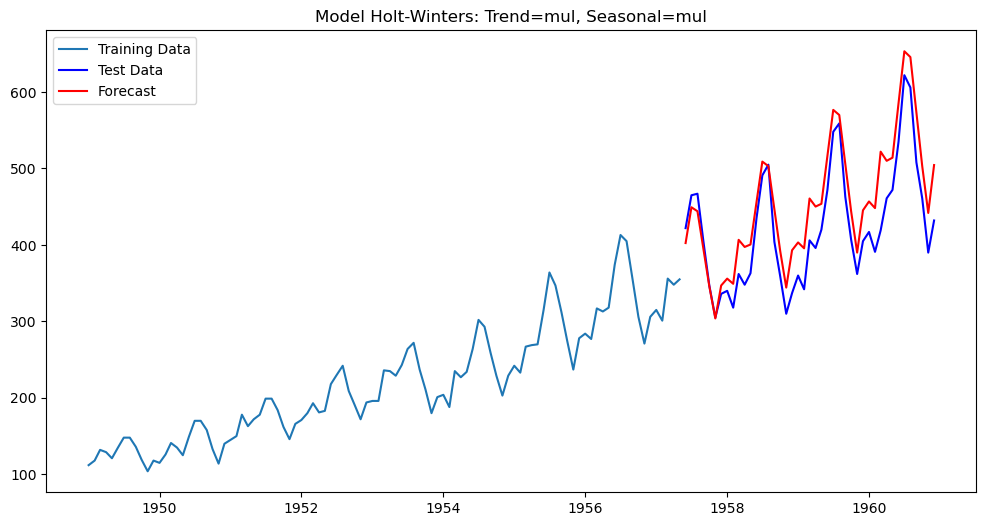

Root Mean Squared Error (mul, mul): 41.91


In [14]:
# Fungsi untuk membuat dan mengevaluasi model Holt-Winters
def evaluate_model(train, test, trend, seasonal, seasonal_periods=12):
    model = ExponentialSmoothing(train['passengers'], 
                                  trend=trend, 
                                  seasonal=seasonal, 
                                  seasonal_periods=seasonal_periods)
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=len(test))
    test['forecast'] = forecast.values
    
    # Plot hasil
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['passengers'], label='Training Data')
    plt.plot(test.index, test['passengers'], label='Test Data', color='blue')
    plt.plot(test.index, test['forecast'], label='Forecast', color='red')
    plt.title(f'Model Holt-Winters: Trend={trend}, Seasonal={seasonal}')
    plt.legend()
    plt.show()
    
    # Evaluasi model
    mse = mean_squared_error(test['passengers'], test['forecast'])
    rmse = np.sqrt(mse)
    
    print(f"Root Mean Squared Error ({trend}, {seasonal}): {rmse:.2f}")

# Evaluasi berbagai konfigurasi model
configurations = [
    ('mul', 'add'),  # Trend multiplicative, Seasonal additive
    ('add', 'mul'),  # Trend additive, Seasonal multiplicative
    ('add', 'add'),  # Trend additive, Seasonal additive
    ('mul', 'mul')   # Trend multiplicative, Seasonal multiplicative
]

for trend, seasonal in configurations:
    evaluate_model(train, test, trend, seasonal)

Model terbaik untuk metode ETS (Exponential Smoothing State Space Model) menggunakan konfigurasi sebagai berikut: **Trend = Additive** dan **Seasonal = Multiplicative.**

dengan RMSE : 27.97

# SARIMA

Checking stationarity of original data:
ADF Statistic: 0.7485846966835923
p-value: 0.9907592216384652
Critical Values: {'1%': -3.5078527246648834, '5%': -2.895382030636155, '10%': -2.584823877658872}
Data is not stationary


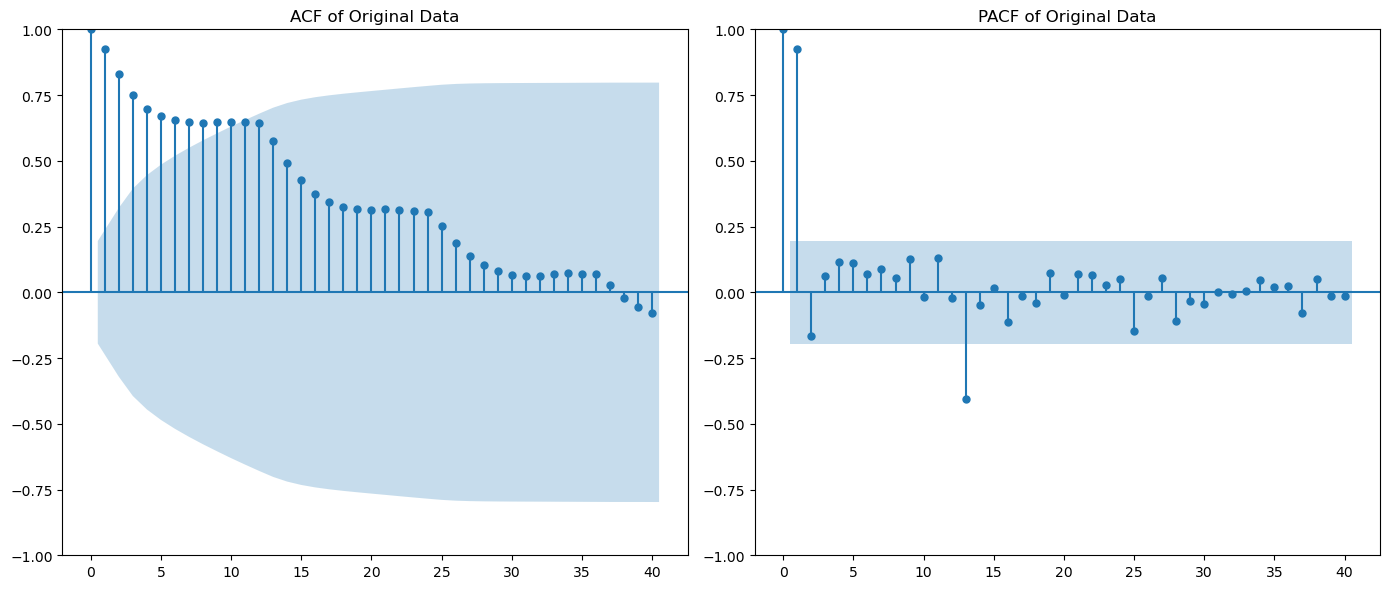

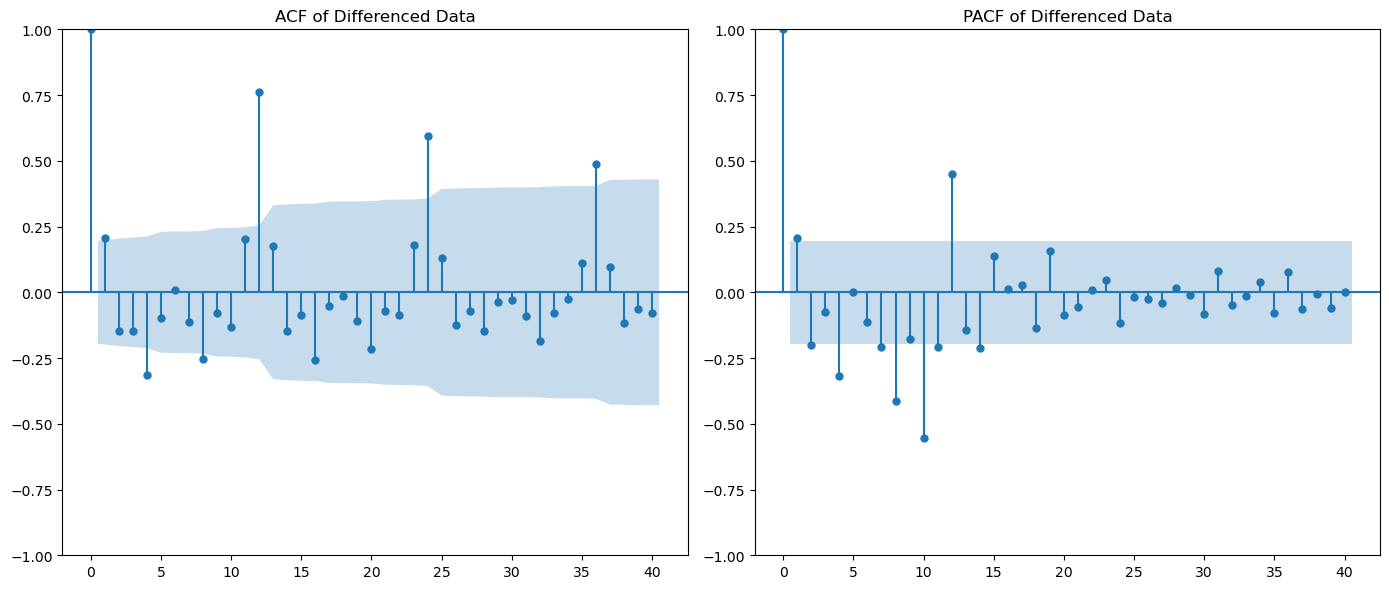

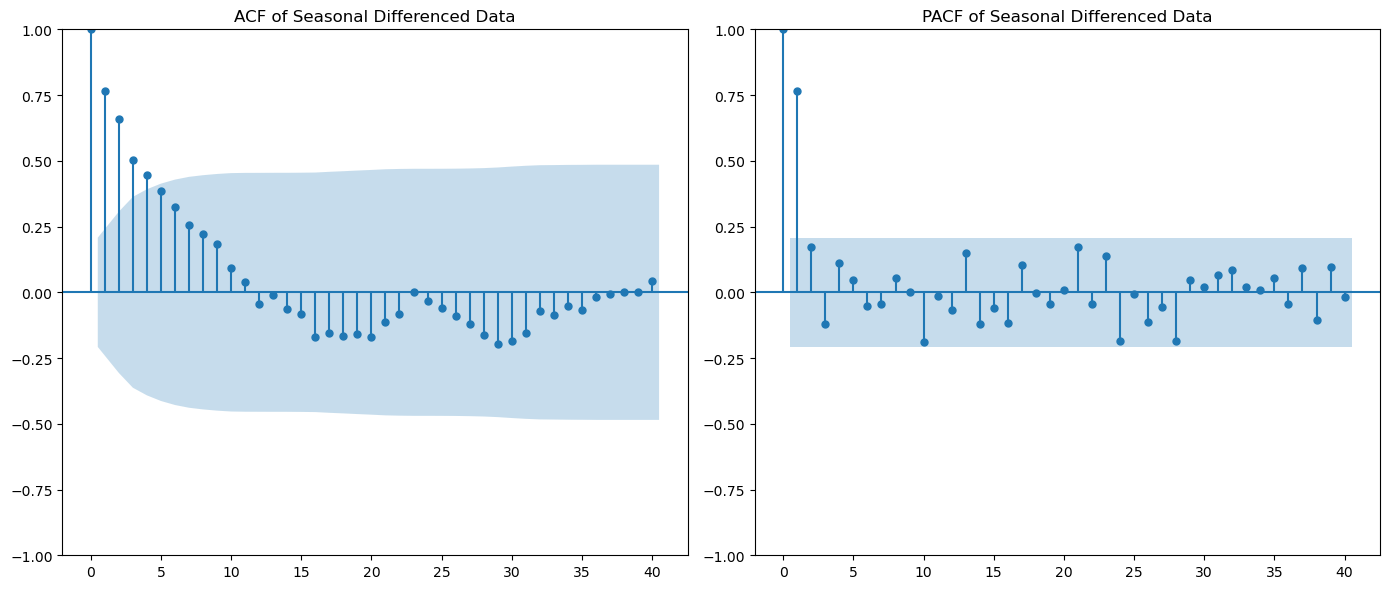

In [15]:
# Fungsi untuk memeriksa stasionaritas
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary")

# Periksa stasionaritas pada data asli
print("Checking stationarity of original data:")
check_stationarity(train['passengers'])

# Plot ACF dan PACF pada data asli
plt.figure(figsize=(14, 6))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(train['passengers'], ax=plt.gca(), lags=40)
plt.title('ACF of Original Data')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(train['passengers'], ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF of Original Data')

plt.tight_layout()
plt.show()

# Menggunakan differencing untuk mencapai stasionaritas
train_diff = train['passengers'].diff().dropna()

# Plot ACF dan PACF pada data yang telah mengalami differencing
plt.figure(figsize=(14, 6))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(train_diff, ax=plt.gca(), lags=40)
plt.title('ACF of Differenced Data')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(train_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF of Differenced Data')

plt.tight_layout()
plt.show()

# Identifikasi parameter musiman
seasonal_periods = 12  # Misalnya, data bulanan dengan pola tahunan

# Untuk menentukan P, D, Q, lakukan seasonal differencing dan analisis ACF/PACF
train_seasonal_diff = train['passengers'].diff(seasonal_periods).dropna()

# Plot ACF dan PACF pada data yang telah mengalami seasonal differencing
plt.figure(figsize=(14, 6))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(train_seasonal_diff, ax=plt.gca(), lags=40)
plt.title('ACF of Seasonal Differenced Data')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(train_seasonal_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF of Seasonal Differenced Data')

plt.tight_layout()
plt.show()

# Jelaskan penentuan pdq manual

In [16]:
model_auto_arima = pm.auto_arima(
    train['passengers'],
    seasonal=True,
    m=12,  # Periode musiman
    trace=True
)

# Tampilkan parameter terbaik
print("Best ARIMA parameters found:", model_auto_arima.order, model_auto_arima.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=654.029, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=657.288, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=650.553, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=651.123, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=652.376, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=652.523, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=652.538, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=650.954, Time=0.08 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=653.919, Time=0.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=652.418, Time=0.08 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=651.963, Time=0.10 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=650.738, Time=0.06 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=653.897, Time=0.26 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

In [17]:
def evaluate_sarima_model(train, test, order, seasonal_order):
    model = SARIMAX(train['passengers'], order=order, seasonal_order=seasonal_order)
    fitted_model = model.fit(disp=False)
    forecast = fitted_model.forecast(steps=len(test))
    test['forecast'] = forecast.values
    
    # Plot hasil
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['passengers'], label='Training Data')
    plt.plot(test.index, test['passengers'], label='Test Data', color='blue')
    plt.plot(test.index, test['forecast'], label='Forecast', color='red')
    plt.title(f'SARIMA Model: Order={order}, Seasonal Order={seasonal_order}')
    plt.legend()
    plt.show()
    
    # Evaluasi model
    mse = mean_squared_error(test['passengers'], test['forecast'])
    rmse = np.sqrt(mse)
    
    print(f"Root Mean Squared Error ({order}, {seasonal_order}): {rmse:.2f}")

In [29]:
def finding_best_parameter_sarima(train, test, p_values, d_values, q_values, seasonal_order):
    results = []
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                
                model = SARIMAX(train['passengers'], order=order, seasonal_order=seasonal_order)
                fitted_model = model.fit(disp=False)
                forecast = fitted_model.forecast(steps=len(test))
                test['forecast'] = forecast.values
                
                # Evaluasi model
                mse = mean_squared_error(test['passengers'], test['forecast'])
                rmse = np.sqrt(mse)
                
                results.append((order, seasonal_order, rmse))
                
                # Print hasil evaluasi
                print(f"Order={order}, Seasonal Order={seasonal_order} -> RMSE: {rmse:.2f}")
    
    # Cari hasil terbaik
    best_result = min(results, key=lambda x: x[2])  # Minimize RMSE
    best_order, best_seasonal_order, best_rmse = best_result
    
    print(f"\nBest Model: Order={best_order}, Seasonal Order={best_seasonal_order}")
    print(f"Best RMSE: {best_rmse:.2f}")
    
# parameter yang ingin diuji
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
seasonal_order = (1, 1, 3, 12)

# Panggil fungsi
finding_best_parameter_sarima(train, test, p_values, d_values, q_values, seasonal_order)

Order=(0, 0, 0), Seasonal Order=(1, 1, 3, 12) -> RMSE: 18.46
Order=(0, 0, 1), Seasonal Order=(1, 1, 3, 12) -> RMSE: 18.31
Order=(0, 0, 2), Seasonal Order=(1, 1, 3, 12) -> RMSE: 20.98
Order=(0, 1, 0), Seasonal Order=(1, 1, 3, 12) -> RMSE: 27.46
Order=(0, 1, 1), Seasonal Order=(1, 1, 3, 12) -> RMSE: 27.97
Order=(0, 1, 2), Seasonal Order=(1, 1, 3, 12) -> RMSE: 27.93
Order=(1, 0, 0), Seasonal Order=(1, 1, 3, 12) -> RMSE: 27.26
Order=(1, 0, 1), Seasonal Order=(1, 1, 3, 12) -> RMSE: 19.95
Order=(1, 0, 2), Seasonal Order=(1, 1, 3, 12) -> RMSE: 19.57
Order=(1, 1, 0), Seasonal Order=(1, 1, 3, 12) -> RMSE: 27.87
Order=(1, 1, 1), Seasonal Order=(1, 1, 3, 12) -> RMSE: 27.72
Order=(1, 1, 2), Seasonal Order=(1, 1, 3, 12) -> RMSE: 27.90
Order=(2, 0, 0), Seasonal Order=(1, 1, 3, 12) -> RMSE: 22.18
Order=(2, 0, 1), Seasonal Order=(1, 1, 3, 12) -> RMSE: 24.89
Order=(2, 0, 2), Seasonal Order=(1, 1, 3, 12) -> RMSE: 27.90
Order=(2, 1, 0), Seasonal Order=(1, 1, 3, 12) -> RMSE: 27.86
Order=(2, 1, 1), Seasona

### Best ETS Model
- Root Mean Squared Error (add, mul): 27.97

### Best Sarima Parameter

Manual Parameter:

- Root Mean Squared Error ((1, 2, 3), (1, 2, 3, 12)): 26.20 

- Root Mean Squared Error ((1, 1, 1), (1, 1, 1, 12)): 26.72
    
- Root Mean Squared Error ((1, 1, 3), (1, 1, 3, 12)): 27.69
   
- Root Mean Squared Error ((1, 1, 2), (1, 1, 2, 12)): 29.61

Auto Arima:
    
- Root Mean Squared Error ((1, 1, 0), (1, 1, 0, 12)): 27.12


#### Root Mean Squared Error ((0, 0, 1), (1, 1, 3, 12)): 18.31 **(Best Parameter)**

# Best Model

C:\Users\muham\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\muham\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\muham\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


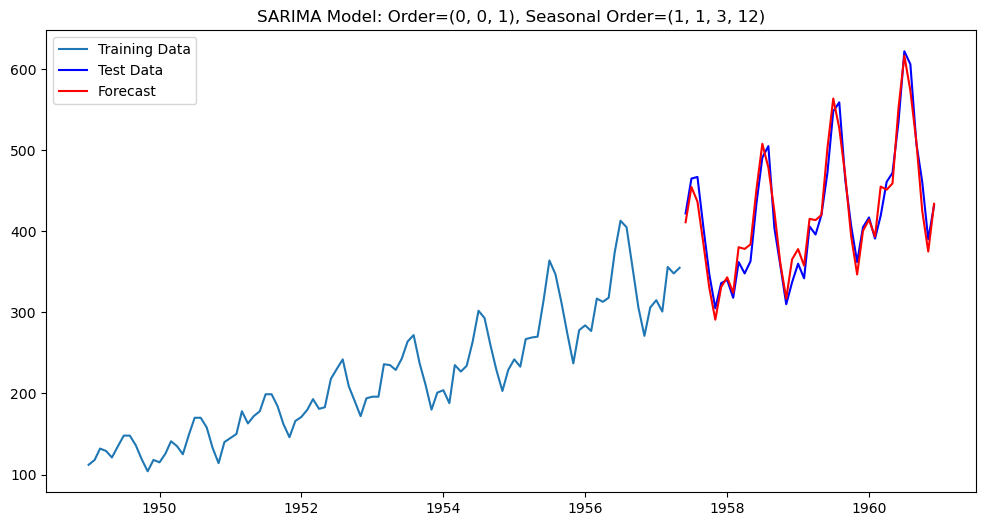

Root Mean Squared Error ((0, 0, 1), (1, 1, 3, 12)): 18.31


In [19]:
order = (0, 0, 1)
seasonal_order = (1, 1, 3, 12)

evaluate_sarima_model(train, test, order, seasonal_order)

# FORECAST (2 Tahun)

In [20]:
futureDate = pd.DataFrame(pd.date_range(start='1961-01-01', end='1962-12-01', freq='MS'), columns=['Dates'])
futureDate.set_index('Dates', inplace=True)
futureDate.head()

""
Dates
1961-01-01
1961-02-01
1961-03-01
1961-04-01
1961-05-01


In [21]:
model = SARIMAX(train['passengers'], order=(0, 0, 1), seasonal_order=(1,1,3,12))
model_fit = model.fit()

predictions = model_fit.predict(start=test.index[0], end= test.index[-1])

df['sarimaxPred'] = predictions

C:\Users\muham\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\muham\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\muham\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:>

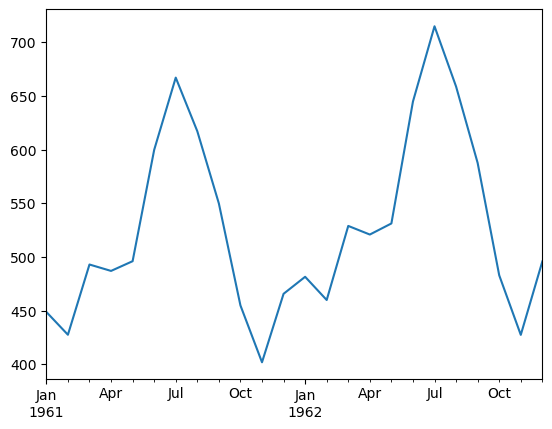

In [22]:
model_fit.predict(start=futureDate.index[0], end=futureDate.index[-1]).plot()

<AxesSubplot:title={'center':'Forecasting Passengers in 2 years (1961 and 1962)'}, xlabel='Years', ylabel='Passengers'>

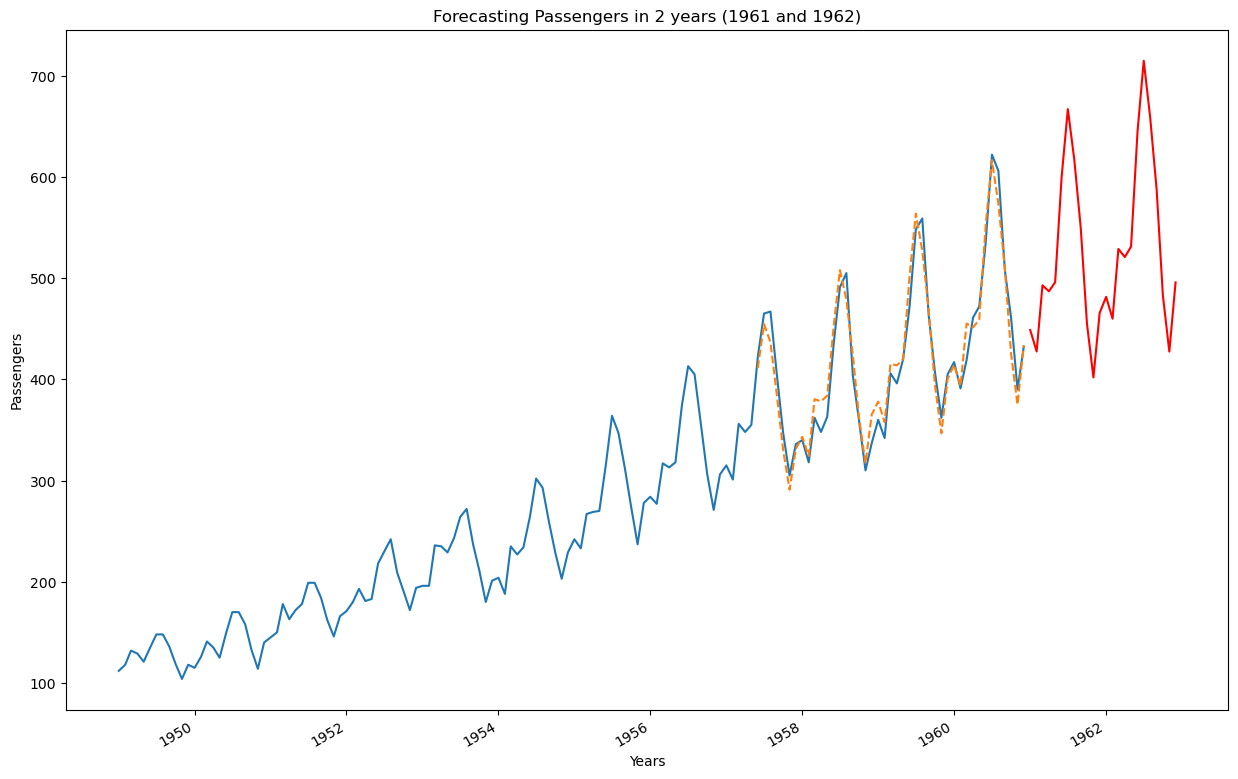

In [23]:
plt.figure(figsize=(15,10))
sns.lineplot(data=df, x=df.index, y= 'passengers')
sns.lineplot(data=df, x=df.index, y= 'sarimaxPred', linestyle='--')

plt.xlabel('Years')
plt.ylabel('Passengers')
plt.title('Forecasting Passengers in 2 years (1961 and 1962)')
model_fit.predict(start=futureDate.index[0], end=futureDate.index[-1]).plot(color='r')